In [ ]:
#ابتدا تمام بسته های مورد نیاز را وارد می کنیم
## imports ##
from abc import ABC,abstractmethod
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer,make_regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_squared_error,mean_absolute_error,r2_score

In [ ]:
#در این مرحله  کلاسی می سازیم که عملکرد هر گره را در درخت ما تعریف می کند
#class to control tree node
class Node:
    #initializer
    def __init__(self): #ین تابع مقداردهی اولیه است که با اعلام یک نمونه کلاس به طور خودکار اجرا می شود. پارامترهای مدل در اینجا مقداردهی اولیه می شوند
        self.__Bs    = None
        self.__Bf    = None
        self.__left  = None
        self.__right = None
        self.leafv   = None

    #تنظیم پارامترهای تقسیم، ویژگی برای این گره
    #set the split,feature parameters for this node
    def set_params(self,Bs,Bf):
        self.__Bs = Bs
        self.__Bf = Bf

    #پارامترهای تقسیم، ویژگی را برای این گره دریافت کنید
    #get the split,feature parameters for this node
    def get_params(self):
        return(self.__Bs,self.__Bf)

    #گره های فرزند چپ/راست را برای این گره فعلی تنظیم کنید
    #set the left/right children nodes for this current node
    def set_children(self,left,right):
        self.__left  = left
        self.__right = right

    #گره فرزند سمت چپ را برگردانید
    #get the left child node
    def get_left_node(self):
        return(self.__left)

    #گره فرزند سمت راست را برگردانید
    #get the right child node
    def get_right_node(self):
        return(self.__right)

In [ ]:
#کلاس پایه برای در بر گرفتن الگوریتم درخت تصمیم
#base class to encompass the decision tree algorithm
class DecisionTree(ABC):
    #initializer
    def __init__(self,max_depth=None,min_samples_split=2):
        self.tree              = None
        self.max_depth         = max_depth #حداکثر تعداد سطوح مجاز را در هنگام رشد درخت تعیین می کند (پیش فرض هیچکدام).
        self.min_samples_split = min_samples_split # حداقل تعداد نمونه را برای اجازه دادن به یک تقسیم در هر گره معینی تعریف می کند (پیش فرض 2).
        #هر دوی این پارامترهای فوق برای جلوگیری از تطبیق بیش از حد درخت روی داده‌های آموزشی عمل می‌کنند و باید از طریق اعتبارسنجی متقابل در مجموعه داده تعیین شوند.

    #تابع محافظت شده برای تعریف ناخالصی
    #protected function to define the impurity

    def _impurity(self,D):
         pass
     #تابع محافظت شده برای محاسبه مقدار در یک گره برگ
    #protected function to compute the value at a leaf node

    def _leaf_value(self,D):
         pass

     #تابع بازگشتی اختصاصی برای رشد درخت در طول آموزش
    #private recursive function to grow the tree during training
    def __grow(self,node,D,level):

       #تابع ابتدا بررسی می کند که آیا گره فعلی یک گره برگ است یا خیر
        #are we in a leaf node? let's do some check...
        depth = (self.max_depth is None) or (self.max_depth >= (level+1))
        msamp = (self.min_samples_split <= D.shape[0])
        n_cls = np.unique(D[:,-1]).shape[0] != 1
        #اگر گره برگ نیست
        #not a leaf node
        if depth and msamp and n_cls:
            #مقداردهی اولیه پارامترهای تابع
            #initialize the function parameters
            ip_node = None
            feature = None
            split   = None
            left_D  = None
            right_D = None
            #از طریق ترکیب‌های ممکن ویژگی/ مقدار تقسیم  تکرار کنید
            #iterrate through the possible feature/split combinations
            for f in range(D.shape[1]-1):
                for s in np.unique(D[:,f]):
                    #برای ترکیب فعلی مجموعه داده را تقسیم کنید (f,s)،
                    #for the current (f,s) combination, split the dataset
                    D_l = D[D[:,f]<=s]
                    D_r = D[D[:,f]>s]
                    #اطمینان حاصل کنید که آرایه های غیر خالی داریم
                    #ensure we have non-empty arrays
                    if D_l.size and D_r.size:
                      #ناخالصی را محاسبه کنید
                        #calculate the impurity
                        ip  = (D_l.shape[0]/D.shape[0])*self._impurity(D_l) + (D_r.shape[0]/D.shape[0])*self._impurity(D_r)
                        #(f,s)اکنون به روز رسانی ناخالصی و انتخاب از
                        #now update the impurity and choice of (f,s)
                        if (ip_node is None) or (ip < ip_node):
                            ip_node = ip
                            feature = f
                            split   = s
                            left_D  = D_l
                            right_D = D_r
            #تنظیم پارامترهای گره فعلی
            #set the current node's parameters
            node.set_params(split,feature)
            #اعلان گره های فرزند
            #declare child nodes
            left_node  = Node()
            right_node = Node()
            node.set_children(left_node,right_node)
            #بررسی گره های فرزند
            #investigate child nodes
            self.__grow(node.get_left_node(),left_D,level+1)
            self.__grow(node.get_right_node(),right_D,level+1)

        #گره برگ است
        #is a leaf node
        else:
            #مقدار گره را تنظیم کنید و برگردانید
            #set the node value & return
            node.leafv = self._leaf_value(D)
            return
     #تابع بازگشتی اختصاصی برای عبور از درخت (آموزش داده شده).
    #private recursive function to traverse the (trained) tree
    def __traverse(self,node,Xrow):
      #بررسی کنید که آیا ما در یک گره برگ هستیم؟
        #check if we're in a leaf node?
        if node.leafv is None:
          # پارامترها را در گره دریافت کنید
            #get parameters at the node
            (s,f) = node.get_params()
            #تصمیم به چپ یا راست رفتن؟
            #decide to go left or right?
            if (Xrow[f] <= s):
                return(self.__traverse(node.get_left_node(),Xrow))
            else:
                return(self.__traverse(node.get_right_node(),Xrow))
        else:
          #مقدار برگ را برگردانید
            #return the leaf value
            return(node.leafv)
    #آموزش مدل درخت
    #train the tree model
    def train(self,Xin,Yin):
      #داده های ورودی را آماده کنید
        #prepare the input data
        D = np.concatenate((Xin,Yin.reshape(-1,1)),axis=1)
        #گره ریشه درخت را تنظیم کنید
        #set the root node of the tree
        self.tree = Node()
        #درخت را بساز
        #build the tree
        self.__grow(self.tree,D,1)
     # از درخت آموزش دیده پیش بینی کنید
    #make predictions from the trained tree
    def predict(self,Xin):
      #تغییر از طریق ردیف های Xin
        #iterrate through the rows of Xin
        p = []
        for r in range(Xin.shape[0]):
            p.append(self.__traverse(self.tree,Xin[r,:]))
            #پیش‌بینی بازگشت
        #return predictions
        return(np.array(p).flatten())

In [ ]:
#اکنون کلاس فرزند را برای مسائل طبقه بندی، DecisionTreeClassifier تعریف می کنیم
#Decision Tree Classifier
class DecisionTreeClassifier(DecisionTree):
    #initializer
    def __init__(self,max_depth=None,min_samples_split=2,loss='gini'):
        DecisionTree.__init__(self,max_depth,min_samples_split)
        self.loss = loss
    # تابع اختصاصی برای تعریف ناخالصی جینی
    #private function to define the gini impurity
    def __gini(self,D):
        #initialize the output
        G = 0
        #iterrate through the unique classes
        for c in np.unique(D[:,-1]):
            #compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            #compute term for the current c
            G += p*(1-p)
        #return gini impurity
        return(G)
    # تابع خصوصی برای تعریف آنتروپی
    #private function to define the shannon entropy
    def __entropy(self,D):
      # خروجی را مقدار دهی اولیه کنید
        #initialize the output
        H = 0
        #تکرار از طریق کلاس های منحصر به فرد
        #iterrate through the unique classes
        for c in np.unique(D[:,-1]):
            #compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            #compute term for the current c
            H -= p*np.log2(p)
        #return entropy
        return(H)
#----------------------------------------------------
         # تابع اختصاصی برای تعریف ناخالصی جینی
    #private function to define the gini impurity
    def __giniE(self,D):
        #initialize the output
        GH = 0
        #iterrate through the unique classes
        for c in np.unique(D[:,-1]):
          for k in np.unique(D[:1,-1]):
            #compute p for the current c
            pp = D[D[:,-1]==c]
            l = D[D[:1,-1]==k]
            z = pp.intersection(l)
            union = (len(pp) + len(l)) - z
            qq = z / union
            #z= jaccard_set(pp,l)
            o = pp.difference(l) / 2
            GH = (1-o) * qq
            #compute term for the current c
            #GH += p*(1-p)
        #return gini impurity
        return(GH)
#----------------------------------------------------------
    # تابع محافظت شده برای تعریف ناخالصی
    #protected function to define the impurity
    def _impurity(self,D):
      #برای محاسبه ناخالصی گره از تابع ضرر انتخاب شده استفاده کنید
        #use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'gini':
            ip = self.__gini(D)
        #elif self.loss == 'entropy':
           # ip = self.__entropy(D)
        elif self.loss == 'giniE':
            ip = self.__giniE(D)
        #return results
        return(ip)
    # تابع محافظت شده برای محاسبه مقدار در یک گره برگ
    #protected function to compute the value at a leaf node
    def _leaf_value(self,D):
         return(stats.mode(D[:,-1])[0])

In [ ]:
#Decision Tree Regressor
class DecisionTreeRegressor(DecisionTree):
    #initializer
    def __init__(self,max_depth=None,min_samples_split=2,loss='mse'):
        DecisionTree.__init__(self,max_depth,min_samples_split)
        self.loss = loss

    #private function to define the mean squared error
    def __mse(self,D):
        #compute the mean target for the node
        y_m = np.mean(D[:,-1])
        #compute the mean squared error wrt the mean
        E = np.sum((D[:,-1] - y_m)**2)/D.shape[0]
        #return mse
        return(E)

    #private function to define the mean absolute error
    def __mae(self,D):
        #compute the mean target for the node
        y_m = np.mean(D[:,-1])
        #compute the mean absolute error wrt the mean
        E = np.sum(np.abs(D[:,-1] - y_m))/D.shape[0]
        #return mae
        return(E)

    #protected function to define the impurity
    def _impurity(self,D):
        #use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'mse':
            ip = self.__mse(D)
        elif self.loss == 'mae':
            ip = self.__mae(D)
        #return results
        return(ip)

    #protected function to compute the value at a leaf node
    def _leaf_value(self,D):
         return(np.mean(D[:,-1]))

**Classification Model**


In [ ]:
## load classification dataset ##
data = load_breast_cancer()
X    = data.data
y    = data.target

In [ ]:
## what is the shape of the dataset? ##
print('shape of X: ',X.shape)
print('shape of y: ',y.shape)

shape of X:  (569, 30)
shape of y:  (569,)


In [ ]:
## how many samples do I need per class for training? ##
nsampclass = int(np.round(y.shape[0]*0.6/2,decimals=0))
nsampclass

171

In [ ]:
## do train/test split ##
#partition the training data by label
y0 = y[y==0]
y1 = y[y==1]
X0 = X[y==0]
X1 = X[y==1]
#select the elements to remove at random
idx0 = np.random.choice([i for i in range(y0.shape[0])],size=nsampclass,replace=False)
idx1 = np.random.choice([i for i in range(y1.shape[0])],size=nsampclass,replace=False)
#select samples for training
y_train0 = y0[idx0]
y_train1 = y1[idx1]
X_train0 = X0[idx0,:]
X_train1 = X1[idx1,:]
y_train  = np.concatenate((y_train0,y_train1))
X_train  = np.concatenate((X_train0,X_train1))
#use remainder for testing
y_test0 = np.delete(y0,idx0)
y_test1 = np.delete(y1,idx1)
X_test0 = np.delete(X0,idx0,axis=0)
X_test1 = np.delete(X1,idx1,axis=0)
y_test  = np.concatenate((y_test0,y_test1))
X_test  = np.concatenate((X_test0,X_test1))

In [ ]:
from numpy import array

In [ ]:
## declare the classifier and train the model ##
clff = DecisionTreeClassifier(max_depth=5,loss='gini')
clff.train(X_train,y_train)

In [ ]:
## declare the classifier and train the model ##
clff = DecisionTreeClassifier(max_depth=5,loss='giniE')
clff.train(X_train,y_train)

In [ ]:
## generate predictions ##
yp = clff.predict(X_test)

In [ ]:
## evaluate model performance ##
print("accuracy: %.2f" % accuracy_score(y_test,yp))
print("precision: %.2f" % precision_score(y_test,yp))
print("recall: %.2f" % recall_score(y_test,yp))

accuracy: 0.93
precision: 0.99
recall: 0.92


In [ ]:
## import the scikit-learn model ##
from sklearn.tree import DecisionTreeClassifier

In [ ]:
## declare the classifier and train the model ##
clf = DecisionTreeClassifier(max_depth=5,criterion='gini')
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
## generate predictions ##
yp = clf.predict(X_test)

In [ ]:
## evaluate model performance ##
print("accuracy: %.2f" % accuracy_score(y_test,yp))
print("precision: %.2f" % precision_score(y_test,yp))
print("recall: %.2f" % recall_score(y_test,yp))

accuracy: 0.91
precision: 0.99
recall: 0.90


[Text(0.5217391304347826, 0.9166666666666666, 'X[22] <= 104.1\ngini = 0.5\nsamples = 342\nvalue = [171, 171]'),
 Text(0.32608695652173914, 0.75, 'X[27] <= 0.172\ngini = 0.134\nsamples = 166\nvalue = [12, 154]'),
 Text(0.2826086956521739, 0.5833333333333334, 'X[24] <= 0.178\ngini = 0.072\nsamples = 160\nvalue = [6, 154]'),
 Text(0.17391304347826086, 0.4166666666666667, 'X[20] <= 15.78\ngini = 0.05\nsamples = 156\nvalue = [4, 152]'),
 Text(0.08695652173913043, 0.25, 'X[10] <= 0.626\ngini = 0.026\nsamples = 150\nvalue = [2, 148]'),
 Text(0.043478260869565216, 0.08333333333333333, 'gini = 0.014\nsamples = 147\nvalue = [1, 146]'),
 Text(0.13043478260869565, 0.08333333333333333, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.2608695652173913, 0.25, 'X[20] <= 15.955\ngini = 0.444\nsamples = 6\nvalue = [2, 4]'),
 Text(0.21739130434782608, 0.08333333333333333, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.30434782608695654, 0.08333333333333333, 'gini = 0.0\nsamples = 4\nvalue = [0,

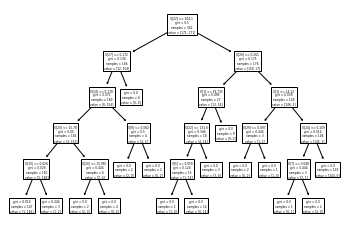

In [ ]:
from sklearn import tree
tree.plot_tree(clf)

In [ ]:
def jaccard_set(list1, list2):
    """Define Jaccard Similarity function for two sets"""
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union



In [ ]:
# تابع اختصاصی برای تعریف ناخالصی جینی
    #private function to define the gini impurity
    def __giniE(self,D):
        #initialize the output
        GH = 0
        #iterrate through the unique classes
        for c in np.unique(D[:,-1]):
          for k in np.unique(D[:1,-1])
            #compute p for the current c
            pp = D[D[:,-1]==c]
            l = D[D[:1,-1]==k]
            #z = p.intersection(l)
            z= jaccard_set(pp,l)
            o = pp.difference(l) / 2
            GH = (1-o) * z
            #compute term for the current c
            #GH += p*(1-p)
        #return gini impurity
        return(GH)